In [1]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/nn_model')

import pickle

import pandas as pd

from nn_model.evaluation_metrics import NormalizedCrossCorrelation
from nn_model.type_variants import EvaluationFields

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def compute_cc_abs_mean_trials_sum(all_predictions, all_targets):
    cc_abs_sum = 0
    for i in range(all_predictions["V1_Exc_L4"].shape[1]):
        print(all_predictions["V1_Exc_L4"].shape)
        predictions = {layer: all_predictions[layer][:, i, :, :] for layer in all_predictions}
        targets = {layer: all_targets[layer][:, i, :, :] for layer in all_targets}
        std_pred, std_target = NormalizedCrossCorrelation._neurons_std(predictions, targets)
        cc_abs_sum += NormalizedCrossCorrelation._cc_abs(predictions, targets, std_pred, std_target)
        
    return cc_abs_sum
        
    


In [3]:
def load_pickle_file(filename: str):
    """
    Loads pickle file.

    :param filename: Name of the pickle file.
    :return: Returns content of the pickle file.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def one_file_cc(filename: str):
    results = load_pickle_file(filename)
    print(results.keys())
    predictions = results[EvaluationFields.PREDICTIONS]
    targets = results[EvaluationFields.TARGETS]
    return compute_cc_abs_mean_trials_sum(predictions, targets)

def cc_mean_abs_trials(directory: str):
    all_cc_sum = 0
    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            filepath = os.path.join(directory, filename)
            all_cc_sum += one_file_cc(filepath)
            
    return all_cc_sum / len(os.listdir(directory))*20 # num trials * num_batches


    
    
    

In [4]:
results_dir = "/home/david/source/diplomka/conference_plots/selected_results/evaluation_results_overall"
model_variants = ["Simple", "DNN", "RNN"]
cc_norms = [0.8672341750727759, 0.8632245083649953, 0.9382373869419098]
cc_abs = [0.7112336999840206, 0.7054749210675557, 0.7670789413981968]
single_trial_cc = [0.2805, 0.2866, 0.3051]
directories = ["simple", "dnn", "syn_adapt"]

rows = []
for i in range(len(model_variants)):
    row = {"model_variant": model_variants[i],
           "Normalized CC": cc_norms[i],
           "Pearson CC": cc_abs[i],
           "Single Trial Pearson CC": single_trial_cc[i],
        #    "trial_separate_cc": cc_mean_abs_trials(os.path.join(results_dir, directories[i])),
        }
    
    rows.append(row)
    
df = pd.DataFrame(rows)


In [5]:
df

,model_variant,Normalized CC,Pearson CC,Single Trial Pearson CC
0,Simple,0.867234,0.711234,0.2805
1,DNN,0.863225,0.705475,0.2866
2,RNN,0.938237,0.767079,0.3051


In [6]:
df_long = pd.melt(df, id_vars='model_variant',
                  value_vars=['Normalized CC', 'Pearson CC', 'Single Trial Pearson CC'],
                  var_name='metric', value_name='value')

/tmp/ipykernel_23652/1679087288.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_23652/1679087288.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='normal', fontsize=28)
/tmp/ipykernel_23652/1679087288.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in ax.get_yticks()], fontweight='normal', fontsize=28)
/tmp/ipykernel_23652/1679087288.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_

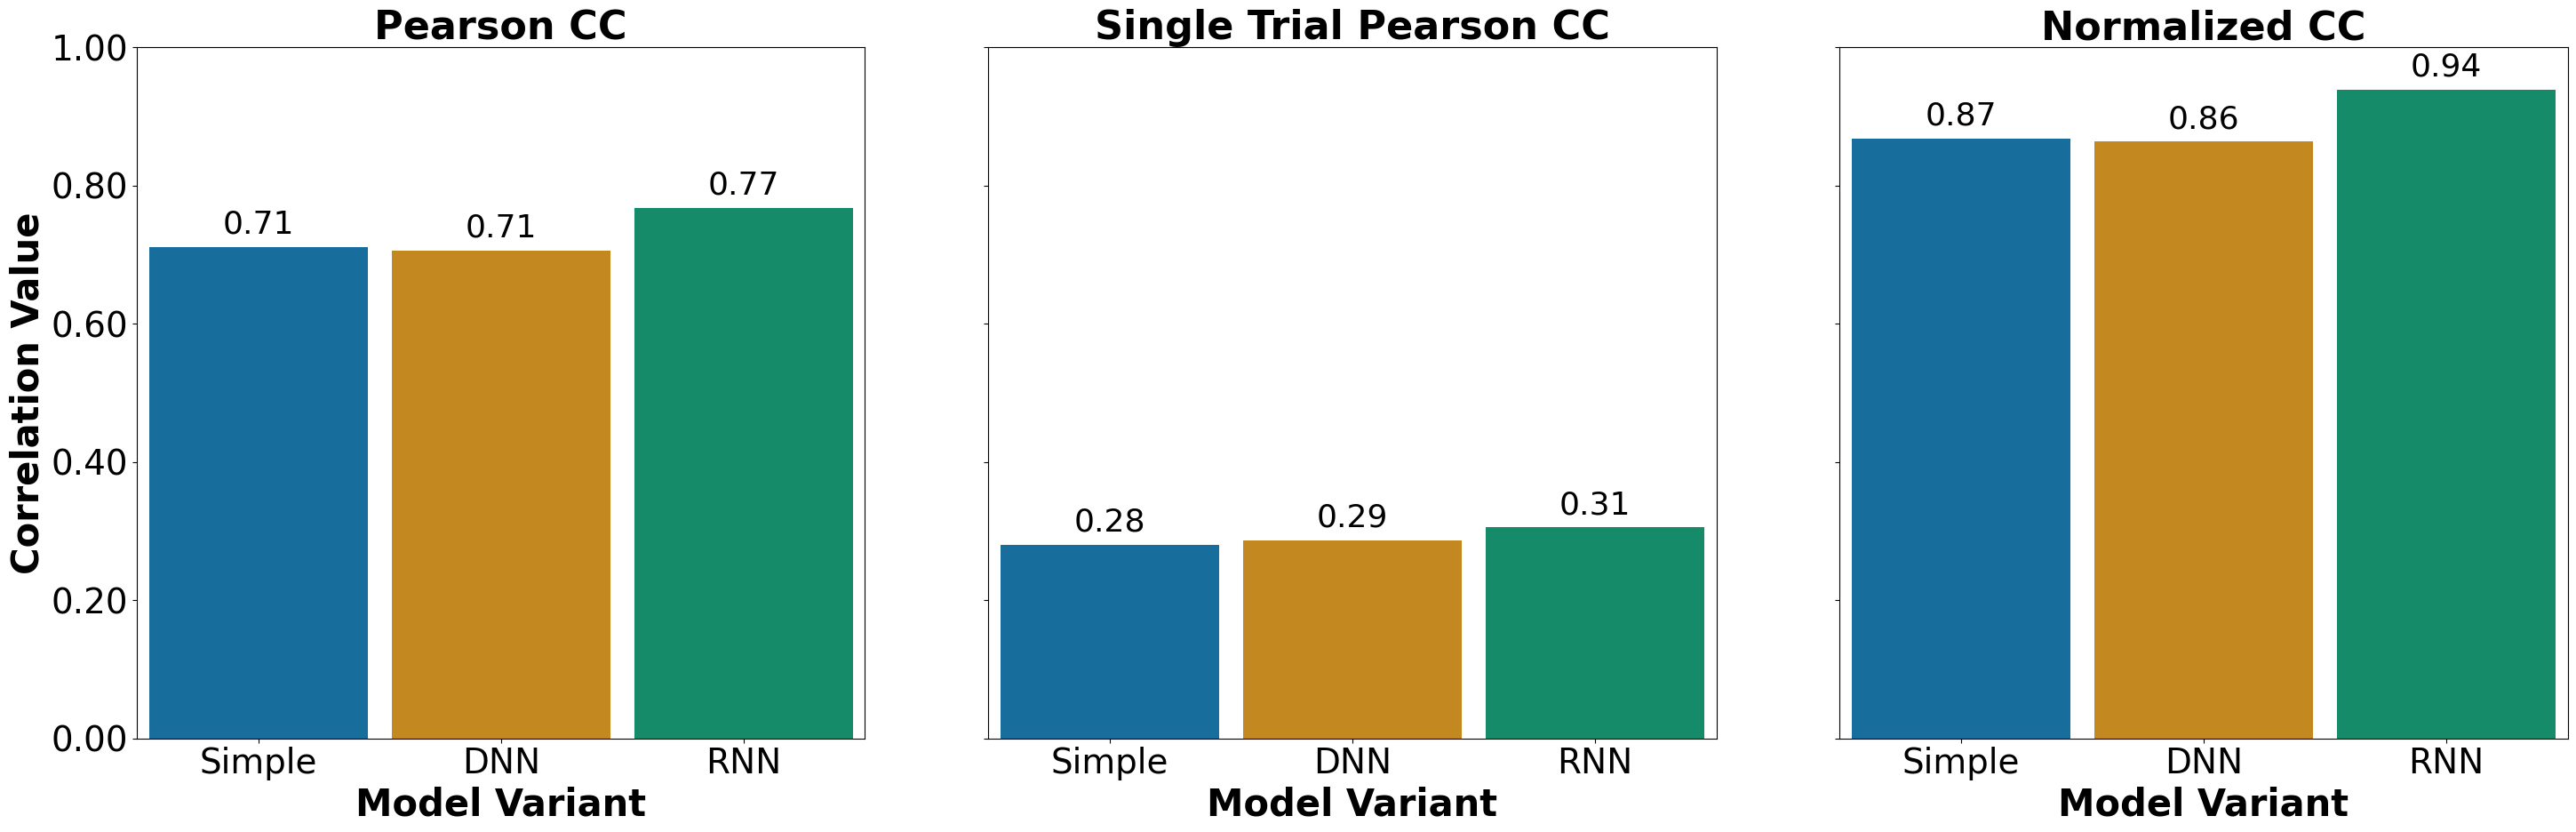

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Global font settings
plt.rcParams.update({
    "font.size": 28,
    "axes.titlesize": 32,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "savefig.dpi": 300
})

# Define metrics in desired custom order
metrics = ['Pearson CC', 'Single Trial Pearson CC', 'Normalized CC']
ylabels = {
    'Pearson CC': 'Pearson Correlation',
    'Single Trial Pearson CC': 'Trial-wise Pearson Correlation',
    'Normalized CC': 'Normalized Correlation Coefficient'
}

# Create a single figure with 3 subplots (side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
plt.subplots_adjust(wspace=30)

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sns.barplot(
        data=df[['model_variant', metric]],
        x='model_variant',
        y=metric,
        palette="colorblind",
        ax=ax,
        width=0.9,
    )

    # Titles and labels
    ax.set_title(metric, fontweight='bold', fontsize=32)
    ax.set_xlabel("Model Variant", fontweight='bold', fontsize=30)
    if idx == 0:
        ax.set_ylabel("Correlation Value", fontweight='bold', fontsize=30)
    else:
        ax.set_ylabel("")

    # Tick styling
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='normal', fontsize=28)
    ax.set_yticklabels([f"{tick:.2f}" for tick in ax.get_yticks()], fontweight='normal', fontsize=28)

    # Annotate bars with larger font
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=26)

    ax.set_ylim(0, 1)

# Final layout and save
plt.tight_layout()
plt.savefig("combined_barplots.pdf", bbox_inches="tight")
plt.show()
